In [18]:
import pandas as pd
import numpy as np
import torch 
from langdetect import detect, DetectorFactory
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from tqdm import tqdm

In [19]:
df = pd.read_csv("../notes-00000.tsv", sep="\t")

C:\Users\jguo27\AppData\Local\Temp\ipykernel_22128\1137875644.py:1: DtypeWarning: Columns (0: believable, 1: harmful, 2: validationDifficulty) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../notes-00000.tsv", sep="\t")


In [20]:
df = df.dropna(subset=["summary"])

In [21]:
df.shape

(2347608, 24)

In [22]:
df.head()

,noteId,noteAuthorParticipantId,createdAtMillis,tweetId,classification,believable,harmful,validationDifficulty,misleadingOther,misleadingFactualError,...,misleadingSatire,notMisleadingOther,notMisleadingFactuallyCorrect,notMisleadingOutdatedButNotWhenWritten,notMisleadingClearlySatire,notMisleadingPersonalOpinion,trustworthySources,summary,isMediaNote,isCollaborativeNote
0,1783179305159200982,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,1713978050878,1783159712986382830,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,1,The House failed to pass a border protection l...,0,0
1,1783181538789605871,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,1713978583415,1783171851818021181,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,1,...,0,0,0,0,0,0,1,The United States has 50 States https://da...,0,0
2,1783182562279494134,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,1713978827435,1783154445682979015,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,0,0,...,0,0,0,0,0,0,1,TikTok only mentions “ban” and chooses to igno...,0,0
3,1883711635770196070,C784F04F26E124F4D6EC01658D8F5565005D3092741FB3...,1737946826294,1883619411774345444,MISINFORMED_OR_POTENTIALLY_MISLEADING,NaN,NaN,NaN,1,0,...,0,0,0,0,0,0,1,This could be considered a threat https://...,0,0
4,1537142913737428992,5684B38EB58FD8BE75ABA37F0BE040EC70380B002ADF9D...,1655318404027,1377030478167937024,MISINFORMED_OR_POTENTIALLY_MISLEADING,BELIEVABLE_BY_MANY,CONSIDERABLE_HARM,EASY,0,1,...,0,0,0,0,0,0,1,Forbes has a good rundown of the investigation...,0,0


In [23]:
df.shape

(2347608, 24)

In [24]:
df = df.sample(100, random_state=42)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

print(torch.__version__)
print(torch.cuda.is_available())

cuda
2.9.1+rocmsdk20260116
True


In [26]:
MODEL_NAME = "facebook/m2m100_418M"

model = M2M100ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)
tokenizer = M2M100Tokenizer.from_pretrained(MODEL_NAME)


In [ ]:
DetectorFactory.seed = 0

def detect_lang(text: str, default="en") -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.strip()
    if not text:
        return default
    try:
        return detect(text)
    except Exception:
        return default

In [28]:
df["lang"] = df["summary"].apply(detect_lang)

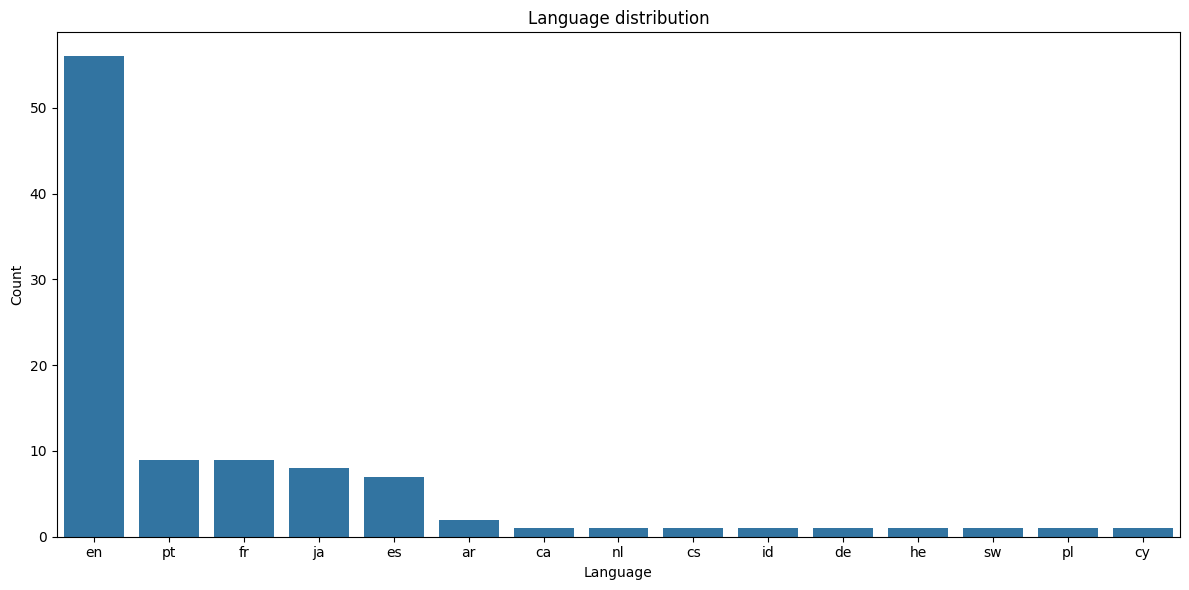

In [42]:
lang_counts = df["lang"].value_counts().reset_index()
lang_counts.columns = ["lang", "count"]

plt.figure(figsize=(12, 6))
sns.barplot(data=lang_counts, x="lang", y="count")
plt.title("Language distribution")
plt.xlabel("Language")
plt.ylabel("Count")
plt.xticks()
plt.tight_layout()
plt.show()

In [ ]:
def translate_to_en(texts, langs, model, tokenizer, device,
                               batch_size=8, max_length=256,
                               translate_english=False):
    assert len(texts) == len(langs)

    buckets = {}
    for idx, lang in enumerate(langs):
        lang = lang or "en"
        if (not translate_english) and lang == "en":
            continue
        buckets.setdefault(lang, []).append(idx)

    results = list(texts)

    model.eval()
    with torch.no_grad():
        for lang, idxs in buckets.items():
            try:
                tokenizer.get_lang_id(lang)
                tokenizer.src_lang = lang
            except Exception:
                tokenizer.src_lang = "en"

            for i in range(0, len(idxs), batch_size):
                batch_idxs = idxs[i:i + batch_size]
                batch_texts = [texts[j] if texts[j] is not None else "" for j in batch_idxs]

                encoded = tokenizer(
                    batch_texts,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=max_length,
                )
                encoded = {k: v.to(device) for k, v in encoded.items()}

                generated = model.generate(
                    **encoded,
                    forced_bos_token_id=tokenizer.get_lang_id("en"),
                    max_new_tokens=128,
                    num_beams=1,
                )

                outs = tokenizer.batch_decode(generated, skip_special_tokens=True)
                for j, out in zip(batch_idxs, outs):
                    results[j] = out

    return results

In [ ]:
texts = df["summary"].fillna("").astype(str).tolist()
langs = df["lang"].fillna("en").astype(str).tolist()

df["summary_en"] = translate_to_en(
    texts=texts,
    langs=langs,
    model=model,
    tokenizer=tokenizer,
    device=device,
    batch_size=32,
    max_length=256,
    translate_english=False,
)


In [31]:
MODEL = "cardiffnlp/tweet-topic-latest-multi"

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
model.eval()

id2label = model.config.id2label

In [ ]:
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))


@torch.no_grad()
def predict_topic_batch(texts, batch_size=32, max_length=128):
    topics = []
    confidences = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        tokens = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        )
        tokens = {k: v.to(device) for k, v in tokens.items()}

        logits = model(**tokens).logits.detach().cpu().numpy()
        probs = _sigmoid(logits)

        for row in probs:
            idx = int(row.argmax())
            topics.append(id2label[idx])
            confidences.append(float(row[idx]))

    return topics, confidences


In [33]:
df["topic"], df["topic_confidence"] = predict_topic_batch(
    df["summary_en"].fillna("").astype(str).tolist(),
    batch_size=32
)


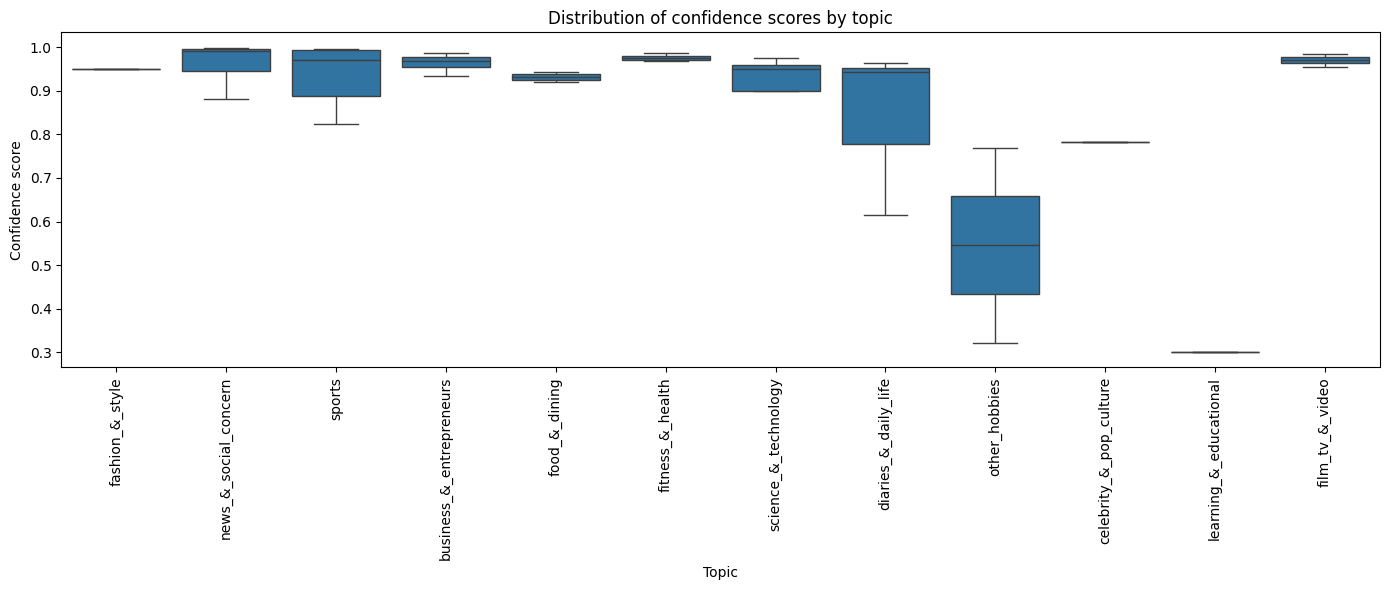

In [34]:
plot_df = df.dropna(subset=["topic", "topic_confidence"])

plt.figure(figsize=(14, 6))

sns.boxplot(
    data=plot_df,
    x="topic",
    y="topic_confidence",
    showfliers=False
)

plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("Confidence score")
plt.title("Distribution of confidence scores by topic")
plt.tight_layout()
plt.show()

In [35]:
political_mask = df["topic"].astype(str).eq("news_&_social_concern")
df_pol = df[political_mask].copy()

print("political rows:", len(df_pol))
df_pol[["topic", "summary_en"]].head()


political rows: 67


,topic,summary_en
905747,news_&_social_concern,"While a 6.2% inflation rate is high, it's cert..."
400902,news_&_social_concern,NNN - The military police do not make public a...
487763,news_&_social_concern,"NNN; after the US, Germany is also by far the ..."
254666,news_&_social_concern,He was an illegal immigrant who was deported 4...
907091,news_&_social_concern,This is a lie. Image depicts one of the dir...


In [36]:
MODEL = "manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2024-1-1"

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
model = AutoModelForSequenceClassification.from_pretrained(MODEL).to(device)
model.eval()

id2label = model.config.id2label

In [37]:
@torch.no_grad()
def predict_manifestoberta(texts, batch_size=32, max_length=200):
    labels = []
    confs = []

    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]

        inputs = tokenizer(
            batch,
            return_tensors="pt",
            max_length=max_length,
            padding="max_length",
            truncation=True,
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        logits = model(**inputs).logits
        probs = torch.softmax(logits, dim=1)

        top_probs, top_idx = torch.max(probs, dim=1)

        for p, idx in zip(top_probs.detach().cpu().tolist(), top_idx.detach().cpu().tolist()):
            p = float(p)
            labels.append(id2label[int(idx)])
            confs.append(p)

    return labels, confs


In [38]:
texts_pol = df_pol["summary_en"].fillna("").astype(str).tolist()

subcat, subcat_conf = predict_manifestoberta(
    texts_pol,
    batch_size=32
)

df.loc[political_mask, "political_subcategory"] = subcat
df.loc[political_mask, "political_subcat_conf"] = subcat_conf

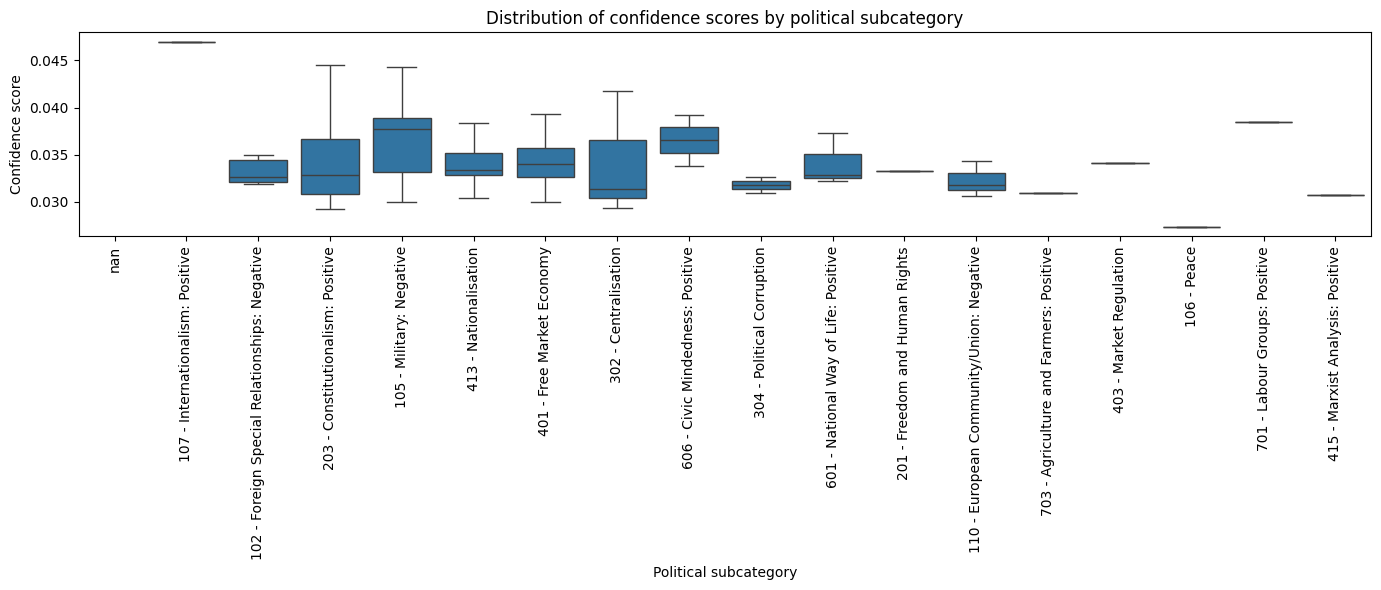

In [39]:


plt.figure(figsize=(14, 6))

sns.boxplot(
    data=df,
    x="political_subcategory",
    y="political_subcat_conf",
    showfliers=False
)

plt.xticks(rotation=90)
plt.xlabel("Political subcategory")
plt.ylabel("Confidence score")
plt.title("Distribution of confidence scores by political subcategory")
plt.tight_layout()
plt.show()


In [40]:
df.to_csv("notes_with_topics.tsv", sep="\t", index=False)